# Case Analysis including actions

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [2]:
# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [3]:
# paths
DIRECTORY_PATH = os.path.dirname(os.getcwd())
os.chdir(DIRECTORY_PATH)

DATA_PATH   = os.path.join(os.getcwd(), "data", "input")
RESULT_PATH = os.path.join(os.path.dirname(os.getcwd()), "results")
MODEL_PATH  = os.path.join(os.getcwd(), "models")

In [4]:
# experiment name
EXPERIMENT_FOLDER = "01 - Cross-validation by state"
try: 
    assert os.path.exists(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))
except AssertionError:
    os.mkdir(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))

In [5]:
# Load MDP packages
import codes.mdp_model as mdp
from codes.mdp_testing import mape, plot_pred
from codes.mdp_states_functions import createSamples
# from codes.utils import run_script # for multiprocessing

In [5]:
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))

In [6]:
for columns in df.columns :
    print("column name : {} - {} NaN".format(columns, df[columns].isnull().mean()))
    
print(df.isnull().mean().mean())

column name : Unnamed: 0 - 0.0 NaN
column name : state - 0.0 NaN
column name : date - 0.0 NaN
column name : cases - 0.0 NaN
column name : deaths - 0.0 NaN
column name : population - 0.034482758620689655 NaN
column name : emergdec - 0.0 NaN
column name : schoolclose - 0.0 NaN
column name : barrestrict - 0.0 NaN
column name : gathrestrict25 - 0.0 NaN
column name : gathrestrictany - 0.0 NaN
column name : otherbusinessclose - 0.0 NaN
column name : restaurantrestrict - 0.0 NaN
column name : gathrestrict10 - 0.0 NaN
column name : caseisolation - 0.0 NaN
column name : stayathome - 0.0 NaN
column name : publicmask - 0.0 NaN
column name : quarantine - 0.0 NaN
column name : nebusinessclose - 0.0 NaN
column name : travelrestrictintra - 0.0 NaN
column name : gathrestrict50 - 0.0 NaN
column name : gathrecomany - 0.0 NaN
column name : gathrestrict250 - 0.0 NaN
column name : gathrestrict5 - 0.0 NaN
column name : gathrestrict100 - 0.0 NaN
column name : gathrestrict1000 - 0.0 NaN
column name : gathrest

In [7]:
# Exception
df = df[df["state"]!='Guam']
df = df[df["state"]!='Northern Mariana Islands']
df = df[df["state"]!='Puerto Rico']
df = df[df["state"]!='Diamond Princess']
df = df[df["state"]!='Grand Princess']
df = df[df["state"]!='American Samoa']
df = df[df["state"]!='Virgin Islands']

In [8]:
df.dropna(subset=["population"], inplace=True)
df["cases_nom"] = df["cases"] / df["population"]
df["deaths_nom"] = df["deaths"] / df["population"]

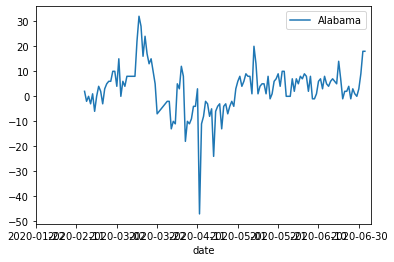

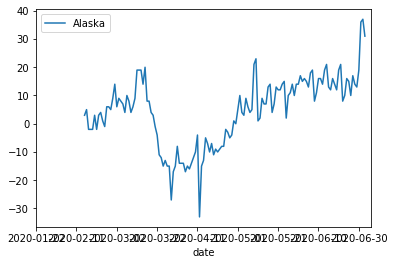

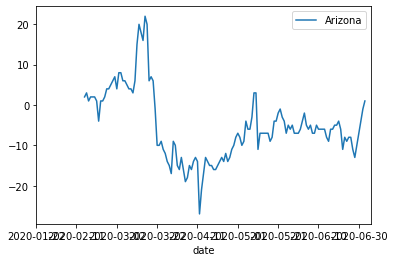

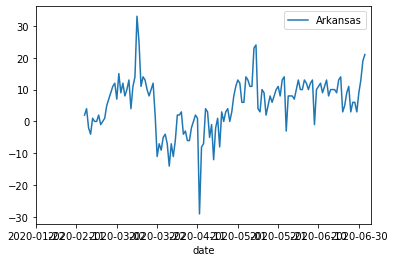

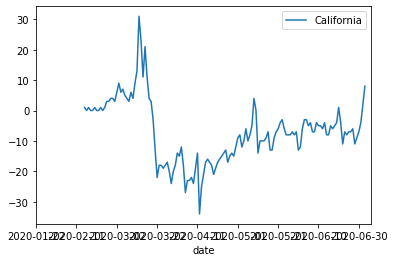

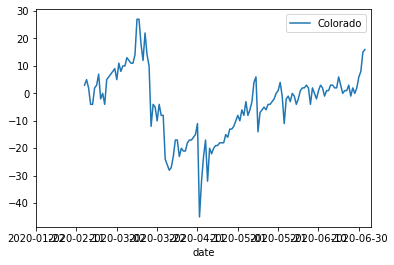

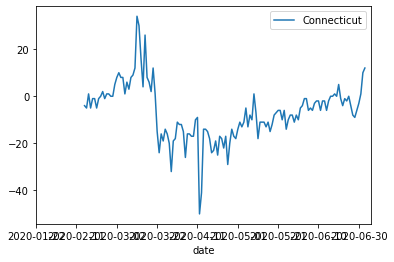

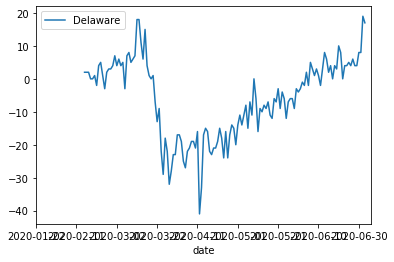

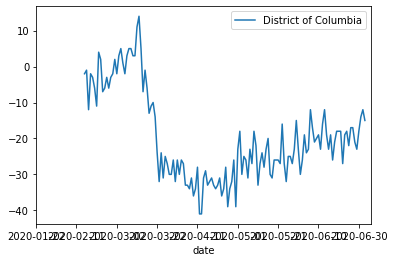

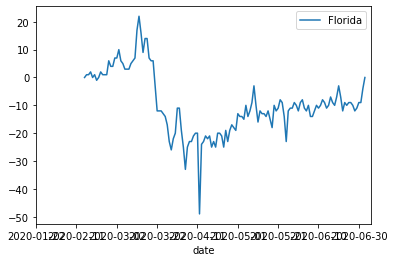

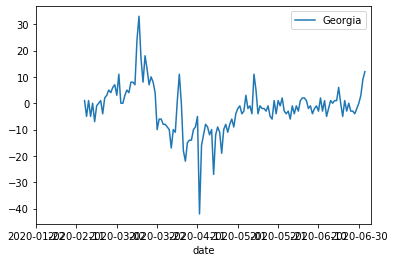

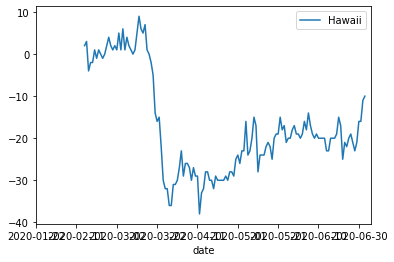

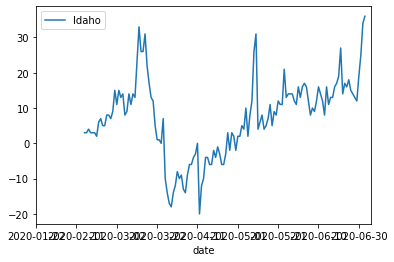

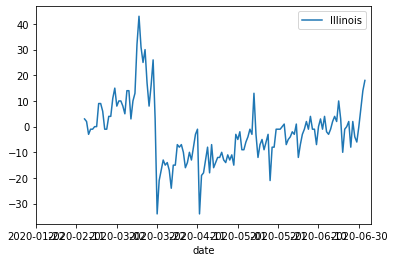

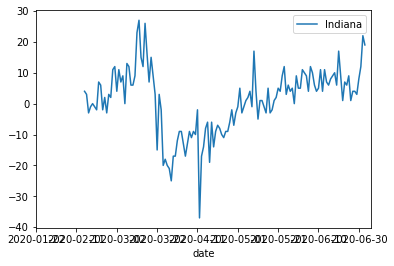

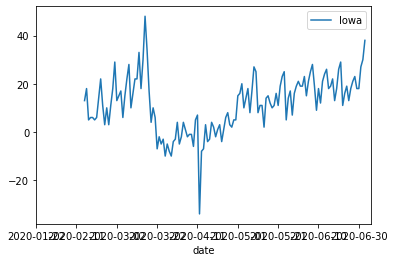

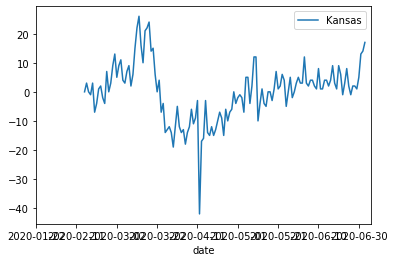

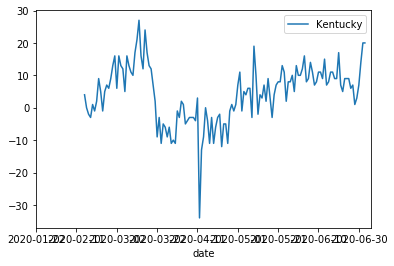

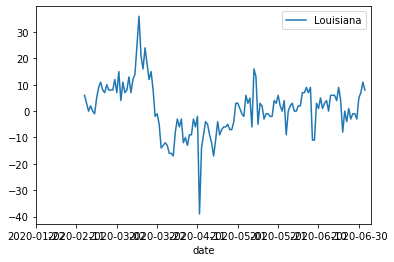

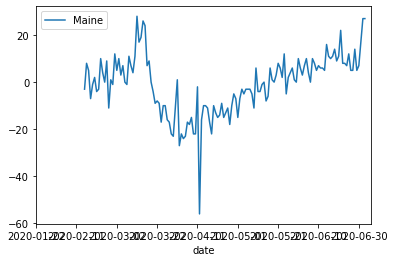

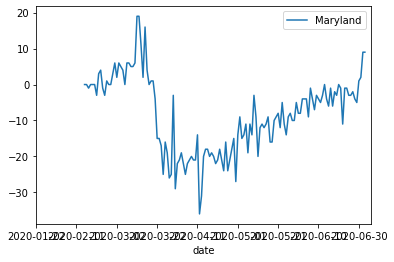

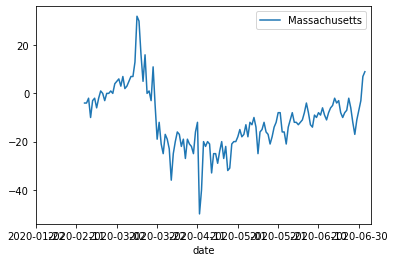

In [9]:
# plotting for a specific feature by region

feature = "grocery_and_pharmacy"
for id_, (name, group) in enumerate(df.groupby("state")):
    group.plot(x="date", y=feature, label=name)
    if id_ > 20 :
        break
plt.legend()
plt.show()

## New features

In [10]:
df.sort_values(by=["state", "date"], inplace=True)
df["cases_pct2"] = df.groupby("state")["cases"].pct_change(2)
df["cases_pct5"] = df.groupby("state")["cases"].pct_change(5)
df["cases_pct10"] = df.groupby("state")["cases"].pct_change(10)
df["deaths_pct2"] = df.groupby("state")["deaths"].pct_change(2)
df["deaths_pct5"] = df.groupby("state")["deaths"].pct_change(5)
df["cases_pct10"] = df.groupby("state")["cases"].pct_change(10)
df["residential_pct10"]= df.groupby("state")["residential"].pct_change(10)
# df["home_time_pct10"]= df.groupby("state")["home_time"].pct_change(10)

In [11]:
file_new = '07_08_2020_states_combined_w_pct.csv'
df.to_csv(os.path.join(DATA_PATH, file_new))

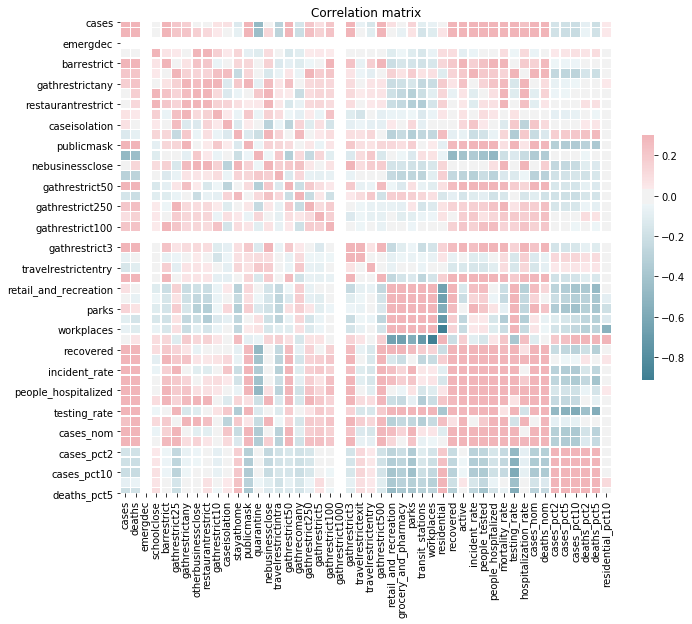

In [12]:
# plot for the covariance matrix between features 
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.loc[:, ~(df.columns.isin(["Unnamed: 0", "state", "date", "population"]))].dropna().corr(method="spearman"), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")
plt.show()

We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

In [15]:
n_days = 15
date_col = 'date'

# take out dates for prediction
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])
split_date = df[date_col].max() - timedelta(n_days)
df_train = df.loc[df[date_col] <= split_date]
df_train

Unnamed: 0    state       date  cases  deaths  population  emergdec  \
0              0  Alabama 2020-01-22      0       0   4903185.0         0   
1              1  Alabama 2020-01-23      0       0   4903185.0         0   
2              2  Alabama 2020-01-24      0       0   4903185.0         0   
3              3  Alabama 2020-01-25      0       0   4903185.0         0   
4              4  Alabama 2020-01-26      0       0   4903185.0         0   
...          ...      ...        ...    ...     ...         ...       ...   
9666        9666  Wyoming 2020-06-17   1114      18    578759.0         1   
9667        9667  Wyoming 2020-06-18   1144      18    578759.0         1   
9668        9668  Wyoming 2020-06-19   1173      20    578759.0         1   
9669        9669  Wyoming 2020-06-20   1179      20    578759.0         1   
9670        9670  Wyoming 2020-06-21   1197      20    578759.0         1   

      schoolclose  barrestrict  gathrestrict25  ...  workplaces  residential  \
0               0            0               0  ...         NaN          NaN   
1               0            0               0  ...         NaN          NaN   
2               0            0               0  ...         NaN          NaN   
3               0            0               0  ...         NaN          NaN   
4               0            0               0  ...         NaN          NaN   
...           ...          ...             ...  ...         ...          ...   
9666            1            0               1  ...       -24.0          5.0   
9667            1            0               1  ...       -24.0          4.0   
9668            1            0               1  ...       -25.0          3.0   
9669            1            0               1  ...        -8.0         -2.0   
9670            1            0               1  ...        -7.0         -3.0   

      recovered  active  incident_rate  people_tested  people_hospitalized  \
0           NaN     NaN            NaN            NaN                  NaN   
1           NaN     NaN            NaN            NaN                  NaN   
2           NaN     NaN            NaN            NaN                  NaN   
3           NaN     NaN            NaN            NaN                  NaN   
4           NaN     NaN            NaN            NaN                  NaN   
...         ...     ...            ...            ...                  ...   
9666      862.0   234.0     192.480808        35069.0                 97.0   
9667      870.0   256.0     197.664313        36154.0                 97.0   
9668      889.0   264.0     202.675034        36474.0                 98.0   
9669      896.0   263.0     203.711735        36480.0                 98.0   
9670      909.0   268.0     206.821838        27359.0                100.0   

      mortality_rate  testing_rate  hospitalization_rate  
0                NaN           NaN                   NaN  
1                NaN           NaN                   NaN  
2                NaN           NaN                   NaN  
3                NaN           NaN                   NaN  
4                NaN           NaN                   NaN  
...              ...           ...                   ...  
9666        1.615799   6059.344218              8.707361  
9667        1.573427   6246.814304              8.479021  
9668        1.705030   6302.105021              8.354646  
9669        1.696353   6303.141722              8.312129  
9670        1.670844   4727.183508              8.354219  

[8816 rows x 44 columns]

## Creating Samples

Usually at this point we will set all the parameters that we use to run `model.fit`, but first I want to show you how the actual training samples are created from the data given (which usually happens within `model.fit`). 

Now this is a very important part! We need to specify a `target` value that our model aims to predict from the training data. The few other things we have to specify include `date_col`, `region_col` and `feature_cols`. `region_col` is the name of the area we are measuring, such as `'state'`, while `feature_cols` are a list of strings we want to use as features, such as `['home_time']`. 

`d_avg` is the number of days we want to average when creating each datapoint, which can help decrease noise if there is a sudden spike in cases at a certain day. 

In [11]:
# Setting parameters
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
feature_cols = ["cases_pct2"]  # action with no features
days_avg = 3

The other parameters relevant to creating samples include an `action_thresh`, which is a list of ints that create cutoff brackets for actions. When `action_thresh` is an empty list `[]`, the default `ACTION = 0` for all datapoints. For example (the other features will be explained below too!):

In [15]:
action_thresh = []
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples

ID       TIME  cases_pct2  cases_pct2-1  cases_pct2-2       r_t  \
0      0 2020-03-28    0.347733      0.873641      0.873641  4.000000   
1      0 2020-03-31    0.208231      0.347733      0.873641  3.416667   
2      0 2020-04-03    0.299994      0.208231      0.347733  1.548780   
3      0 2020-04-06    0.210312      0.299994      0.208231  1.409449   
4      0 2020-04-09    0.234083      0.210312      0.299994  1.351955   
...   ..        ...         ...           ...           ...       ...   
1839  50 2020-06-23    0.049104      0.031437      0.045302  1.000000   
1840  50 2020-06-26    0.050892      0.049104      0.031437  1.000000   
1841  50 2020-06-29    0.045068      0.050892      0.049104  1.000000   
1842  50 2020-07-02    0.041137      0.045068      0.050892  1.000000   
1843  50 2020-07-05    0.037917      0.041137      0.045068  1.000000   

         r_t-1     r_t-2      RISK  ACTION    state     deaths  
0     0.000000  0.000000  1.386294       0  Alabama   8.000000  
1     4.000000  0.000000  1.228665       0  Alabama  27.333333  
2     3.416667  4.000000  0.437468       0  Alabama  42.333333  
3     1.548780  3.416667  0.343199       0  Alabama  59.666667  
4     1.409449  1.548780  0.301552       0  Alabama  80.666667  
...        ...       ...       ...     ...      ...        ...  
1839  1.071429  1.037037  0.000000       0  Wyoming  20.000000  
1840  1.000000  1.071429  0.000000       0  Wyoming  20.000000  
1841  1.000000  1.000000  0.000000       0  Wyoming  20.000000  
1842  1.000000  1.000000  0.000000       0  Wyoming  20.000000  
1843  1.000000  1.000000  0.000000       0  Wyoming  20.000000  

[1844 rows x 12 columns]

`createSamples` has taken out some of the smaller regions with missing data, and left only the 50 states + Washington DC. It has then assigned each state to an `ID` number, and compressed the `TIME` to be one datapoint for every `n_days`. 

Next, notice that it has created a `target-1` (`cases-1` here) and `target-2` column, as well as `-1` and `-2` columns for each of the features in `feature_cols`. These are the offsets of 1 or 2 datapoints prior to the current point , respectively. At the beginning of each `ID`, when `-1` and `-2` in the features are empty, we simply substitute in the current value of the feature. 

You will also see the `r_t` rows. This is the ratio of the target value today compared to (divided by) the target value at the data point prior. `RISK` (reward) is assigned as the natural log of the `r_t` value. Note that we have also deleted the rows where `target = 0`, since this is before any of the cases have occured, and will throw an error when calculating `r_t`. 

Now, if we specify `action_thresh` to be these cutoff bins, `[-1e10, -50, 0, 50, 100, 1e10]`, these 6 numbers in the `action_thresh` delineate the start and end range of each `ACTION`, so we will be creating 5 actions total. The ranges are for the `feature_change` of the first feature in the list `feature_cols`. This `feature_change` corresponds to the `t-1` - `t-2` values of this first feature in the list. So for instance in this dataset and the above `action_thresh` with `feature_cols = ['home_time']`, `feature_cols[0] = 'home_time'`: if the `home_time_change = -75` for a certain datapoint, it will be assigned `ACTION=0` (since it is in the first bracket). 

Make sure you set `action_thresh` to encompass the entire range of possible `feature_change` values! What you choose to put as the action-determining feature (listed first in `features_cols`) and where action bin cutoffs are will of course have a big impact on how the model learns the MDP. 

In [16]:
action_thresh = [-1e10, -50, 0, 50, 100, 1e10]
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples

ID       TIME  cases_pct2  cases_pct2-1  cases_pct2-2       r_t  \
0      0 2020-03-28    0.347733      0.873641      0.873641  4.000000   
1      0 2020-03-31    0.208231      0.347733      0.873641  3.416667   
2      0 2020-04-03    0.299994      0.208231      0.347733  1.548780   
3      0 2020-04-06    0.210312      0.299994      0.208231  1.409449   
4      0 2020-04-09    0.234083      0.210312      0.299994  1.351955   
...   ..        ...         ...           ...           ...       ...   
1839  50 2020-06-23    0.049104      0.031437      0.045302  1.000000   
1840  50 2020-06-26    0.050892      0.049104      0.031437  1.000000   
1841  50 2020-06-29    0.045068      0.050892      0.049104  1.000000   
1842  50 2020-07-02    0.041137      0.045068      0.050892  1.000000   
1843  50 2020-07-05    0.037917      0.041137      0.045068  1.000000   

         r_t-1     r_t-2      RISK  cases_pct2_change ACTION    state  \
0     0.000000  0.000000  1.386294           0.000000      2  Alabama   
1     4.000000  0.000000  1.228665          -0.525908      1  Alabama   
2     3.416667  4.000000  0.437468          -0.139503      1  Alabama   
3     1.548780  3.416667  0.343199           0.091763      2  Alabama   
4     1.409449  1.548780  0.301552          -0.089682      1  Alabama   
...        ...       ...       ...                ...    ...      ...   
1839  1.071429  1.037037  0.000000          -0.013864      1  Wyoming   
1840  1.000000  1.071429  0.000000           0.017667      2  Wyoming   
1841  1.000000  1.000000  0.000000           0.001788      2  Wyoming   
1842  1.000000  1.000000  0.000000          -0.005823      1  Wyoming   
1843  1.000000  1.000000  0.000000          -0.003931      1  Wyoming   

         deaths  
0      8.000000  
1     27.333333  
2     42.333333  
3     59.666667  
4     80.666667  
...         ...  
1839  20.000000  
1840  20.000000  
1841  20.000000  
1842  20.000000  
1843  20.000000  

[1844 rows x 13 columns]

Finally, `pfeatures` is the number of features that are used for training, which starts at the target column and ends before the RISK column. Essentially, it is the target, features, and ratio, for the current time point as well as its history `t-1` and `t-2`. 

In [17]:
pfeatures

6

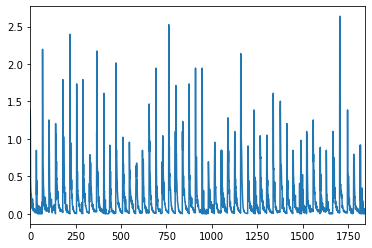

In [18]:
np.log(df_samples.r_t).plot()

## Import fitted model

Now that we understand how the samples are actually created, we can fit the samples to the model! Here, there are a few additional parameters that need to be set: 

`h` is the time horizon (in number of datapoints) that we take when calculating error. Essentially, we will be calculating the error of the most recent `h` points from the end. The goal of the algorithm is to minimize `testing_error`, so `testing_error` for a sequence of `h=1` points will be much smaller than for `h=5` points. If we are doing a 2 week prediction (`n_days = 14`), `h=5` while `d_avg=3` means that 5 datapoints correspond to a 15 day timespan, which means the algorithm will be minimizing error for around a 2 week period before the last date in the training data. If we take `h=-1`, the algorithm will try to minimize error over all the datapoints available in the training data.

`n_iter` is the maximum number of clusters we want the algorithm to stop at while training. Initial clustering is done using `clustering='Agglomerative'`, with a `distance_threshold = 0.1`, based on `RISK`. The algorithm will then split the cluster that contains the most contradictions (two points in the cluster taking the same action but ending up in different clusters), so one cluster becomes two. For points in the same cluster that don't take the action causing the contradiction, the group they enter is decided by `classification = 'DecisionTreeClassifier'`, which learns which group they are closer to based on their features. Splitting will stop when `n_iter` number of total clusters is reached.

`th` is the splitting threshold, which basically allows the split to happen if the number of points in contradiction within a cluster is greater than this `th` value. 

`model.fit` will also automatically run cross validation by splitting the dataset randomly into `cv=5` combinations of testing & training, where each `ID` (state) will be in the testing set exactly once. After cross validation, it will find the number of clusters that gives the smallest `testing_error`, and split the entire dataset once more to this exact number of clusters. Now let's run it!

In [6]:
# # Setting parameters
n_days = 15
date_col = 'date'
target_colname = 'deaths'
region_colname = 'state'
date_colname = 'date'
days_avg = 3


# model names deaths

## features_list = ['home_time', 'part_time']
# model_name = "mdp_time100bis_RF_5pct_deaths.pickle"
# model_name = "mdp_time100_RF_5pct_deaths.pickle"
# model_name = "mdp_id150_RF_5pct_deaths.pickle"  # 6.11% - 8.89%
# model_name = "mdp_id100_RF_5pct_deaths.pickle"  # 5.27% - 7.96%
# model_name = "mdp_id100_RF_10pct_deaths.pickle"  # 3.60% - 4.86% (best)
# model_name = "mdp_time100_RF_10pct_deaths.pickle"  # 3.77% - 5.36%
# model_name = "mdp_time100bis_RF_10pct_deaths.pickle"  # 3.72% - 5.51%
# model_name = "mdp_time100bis_RF_13pct_deaths.pickle"  # 3.65% - 4.99%
# model_name = "mdp_timecv100_DT_h5_10pct_deaths_1f.pickle"  # 3.94% - 5.57%
# model_name = "mdp_idcv100_DT_h5_10pct_deaths.pickle"  # 4.13% - 5.35%
# model_name = "mdp_all100_DT_h5_10pct_deaths.pickle"  # 3.94% - 5.57%
# model_name = "mdp_all100_DT_h5_10pct_deaths.pickle"  # 3.72% - 5.5%
# model_name = "mdp_timecv100_DT_h5_13pct_deaths_1f.pickle"  # 3.72% - 5.5%
# model_name = "mdp_idcv100_DT_h5_13pct_deaths.pickle"
# model_name = "mdp_timecv200_DT_h5_10pct_deaths_fnew.pickle"
model_name = "mdp_timecv100_DT_h5_10pct_deaths_fnew_v2.pickle"  # 3.84 - 5.34% (best)
# model_name = "mdp_timecv100_DT_h5_10pct_deaths_v3.pickle"  # 3.72% - 5.51%
model_name = "mdp_timecv200_DT_h10_10pct_deaths_v5.pickle"

# model name cases
model_name = "mdp_timecv100_DT_h5_10pct_cases_newf.pickle"  # 4.17% - 5.33%
# model_name = "mdp_timecv100_DT_h5_10pct_cases_newf2.pickle"  # 4.17% - 5.87%
# model_name = "mdp_timecv150_DT_h8_10pct_cases_wo_act.pickle"
model_name = "mdp_errorid.pickle"  # 4.17% - 5.33%


In [7]:
# with open(os.path.join(MODEL_PATH, model_name), 'rb') as filehandler:
#     m = pickle.load(filehandler)

with open(r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\12 - 20200723 UPDATED ERROR COMPUTATION\MDPs_without_actions\mdp_cases_wo_act.pickle", 'rb') as filehandler:
    m = pickle.load(filehandler)
# with open(r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\12 - 20200723 UPDATED ERROR COMPUTATION\MDPs\mdp_cases_wo_act.pickle", 'rb') as filehandler:
#     m = pickle.load(filehandler)

## Analysis of the MDP

In [8]:
m.df_trained

ID       TIME  cases_pct3  cases_pct5  cases_pct3-1  \
state                                                                       
Alabama                0 2020-05-22    0.104557    0.161329      0.089471   
Alaska                 1 2020-05-22    0.007500    0.038660      0.032646   
Arizona                2 2020-05-20    0.073683    0.125127      0.081923   
Arkansas               3 2020-05-22    0.139955    0.179239      0.086881   
California             4 2020-05-20    0.077017    0.121779      0.065565   
Colorado               5 2020-05-22    0.044702    0.070608      0.040982   
Connecticut            6 2020-05-21    0.030068    0.063803      0.048681   
Delaware               7 2020-05-20    0.065079    0.111506      0.064695   
District of Columbia   8 2020-05-21    0.066498    0.107018      0.057941   
Florida                9 2020-05-20    0.047597    0.082160      0.051611   
Georgia               10 2020-05-21    0.064889    0.098300      0.048124   
Hawaii                11 2020-05-20    0.005728    0.007827      0.003658   
Idaho                 12 2020-05-22    0.057026    0.072757      0.023874   
Illinois              13 2020-05-22    0.075630    0.119470      0.063559   
Indiana               14 2020-05-20    0.057571    0.096763      0.059478   
Iowa                  15 2020-05-22    0.078190    0.125657      0.071648   
Kansas                16 2020-05-20    0.058334    0.095121      0.045738   
Kentucky              17 2020-05-21    0.044239    0.086889      0.059274   
Louisiana             18 2020-05-21    0.052786    0.071184      0.026147   
Maine                 19 2020-05-22    0.118897    0.154713      0.076805   
Maryland              20 2020-05-21    0.082031    0.145674      0.086660   
Massachusetts         21 2020-05-20    0.034318    0.061297      0.041778   
Michigan              22 2020-05-20    0.032362    0.057166      0.034660   
Minnesota             23 2020-05-22    0.116037    0.212982      0.125683   
Mississippi           24 2020-05-20    0.069066    0.108137      0.062736   
Missouri              25 2020-05-21    0.039323    0.066075      0.040542   
Montana               26 2020-05-20    0.019167    0.024253      0.009327   
Nebraska              27 2020-05-22    0.074443    0.145917      0.076791   
Nevada                28 2020-05-22    0.060457    0.082890      0.050908   
New Hampshire         29 2020-05-22    0.078742    0.116240      0.066511   
New Jersey            30 2020-05-21    0.022075    0.043123      0.029376   
New Mexico            31 2020-05-20    0.065145    0.112757      0.071568   
New York              32 2020-05-22    0.015046    0.022943      0.013287   
North Carolina        33 2020-05-21    0.108586    0.157723      0.081395   
North Dakota          34 2020-05-20    0.139647    0.205102      0.095118   
Ohio                  35 2020-05-21    0.061912    0.100419      0.054544   
Oklahoma              36 2020-05-20    0.053212    0.091192      0.059724   
Oregon                37 2020-05-22    0.037037    0.066519      0.038650   
Pennsylvania          38 2020-05-22    0.043084    0.068661      0.036095   
Rhode Island          39 2020-05-22    0.060613    0.083794      0.052013   
South Carolina        40 2020-05-22    0.064267    0.093240      0.045141   
South Dakota          41 2020-05-20    0.050415    0.074074      0.039756   
Tennessee             42 2020-05-20    0.055580    0.100401      0.056017   
Texas                 43 2020-05-22    0.059088    0.106269      0.070620   
Utah                  44 2020-05-20    0.067755    0.114159      0.068085   
Vermont               45 2020-05-21    0.009556    0.014948      0.007488   
Virginia              46 2020-05-21    0.091752    0.150089      0.083983   
Washington            47 2020-05-21    0.025662    0.045233      0.031517   
West Virginia         48 2020-05-22    0.135153    0.142761      0.044208   
Wisconsin             49 2020-05-20    0.093686    0.144981      0.085162   
Wyoming           

In [9]:
m.features_list

['cases_pct3', 'cases_pct5']

In [10]:
m.clustering_distance_threshold

0.1

We have our model ready for interpretation! Let's first look at some attributes that were stored in the model after training. First, we can see how many clusters it actually ended up with at the final optimal split, as well as the training error of the lowest point of CV: 

In [11]:
print(m.optimal_cluster_size)
print(m.CV_error)
m.verbose=False

37
0.016513212221646194


Now, we can run `model.predict_region_ndays`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [12]:
m.predict_region_ndays('New York', 15)

382139.65599916806

`model.predict_all` does the same thing, but for all the states for a given `n_days`. It returns a dataframe instead of just a number.

In [69]:
m.predict_allregions_ndays(15)

TIME   cases
state                                  
Alabama              2020-06-06   17951
Alaska               2020-06-06     429
Arizona              2020-06-04   20350
Arkansas             2020-06-06    7713
California           2020-06-04  117226
Colorado             2020-06-06   28454
Connecticut          2020-06-05   42064
Delaware             2020-06-04   11137
District of Columbia 2020-06-05   10296
Florida              2020-06-04   58796
Georgia              2020-06-05   53936
Hawaii               2020-06-04     687
Idaho                2020-06-06    3143
Illinois             2020-06-06  138469
Indiana              2020-06-04   39229
Iowa                 2020-06-06   21657
Kansas               2020-06-04   11399
Kentucky             2020-06-05   10123
Louisiana            2020-06-05   44479
Maine                2020-06-06    2592
Maryland             2020-06-05   58521
Massachusetts        2020-06-04  109011
Michigan             2020-06-04   64787
Minnesota            2020-06-06   25290
Mississippi          2020-06-04   16329
Missouri             2020-06-05   14250
Montana              2020-06-04     510
Nebraska             2020-06-06   14128
Nevada               2020-06-06    9116
New Hampshire        2020-06-06    4862
New Jersey           2020-06-05  162267
New Mexico           2020-06-04    8611
New York             2020-06-06  382139
North Carolina       2020-06-05   29291
North Dakota         2020-06-04    3262
Ohio                 2020-06-05   40027
Oklahoma             2020-06-04    7468
Oregon               2020-06-06    4122
Pennsylvania         2020-06-06   85060
Rhode Island         2020-06-06   16641
South Carolina       2020-06-06   11676
South Dakota         2020-06-04    5563
Tennessee            2020-06-04   24848
Texas                2020-06-06   64862
Utah                 2020-06-04   10486
Vermont              2020-06-05    1014
Virginia             2020-06-05   45967
Washington           2020-06-05   20476
West Virginia        2020-06-06    2343
Wisconsin            2020-06-04   19102
Wyoming              2020-06-05     971

We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [70]:
# Import full dataset and convert time col to time object
file = r'C:\Users\david\Dropbox (MIT)\COVID-19-Team2\Data\07_16_2020_states_combined.csv'
df = pd.read_csv(file)
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = pd.concat([m.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname).reset_index()
error_state = error.dropna().drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

rel_error
state                          
New York               0.004303
New Jersey             0.005244
Florida                0.005514
Iowa                   0.007790
Colorado               0.007898
Vermont                0.008941
Maine                  0.009512
Wyoming                0.012155
Mississippi            0.014359
Tennessee              0.014480
Missouri               0.016885
New Hampshire          0.016911
Maryland               0.018507
Montana                0.019139
Nevada                 0.019842
California             0.020002
Utah                   0.020716
Connecticut            0.022033
Massachusetts          0.022665
Idaho                  0.022869
Ohio                   0.023896
Kentucky               0.024397
Wisconsin              0.024646
South Dakota           0.026040
Hawaii                 0.027309
Illinois               0.030230
Pennsylvania           0.030490
Rhode Island           0.030574
New Mexico             0.031162
Michigan               0.033816
Arizona                0.033958
Georgia                0.034465
Louisiana              0.036538
Virginia               0.038222
North Carolina         0.041004
Oregon                 0.043170
Indiana                0.043525
Oklahoma               0.044250
Arkansas               0.045117
West Virginia          0.050374
Washington             0.052409
Texas                  0.054198
District of Columbia   0.055273
Nebraska               0.057412
Kansas                 0.060521
South Carolina         0.063429
Minnesota              0.064501
Delaware               0.066327
Alaska                 0.066673
Alabama                0.076399
North Dakota           0.128415

In [71]:
error.dropna()

state       TIME  cases  real cases  rel_error
0          Alabama 2020-05-23  13920       14117   0.013955
1           Alaska 2020-05-23    404         407   0.007371
2          Arizona 2020-05-21  15641       15348   0.019090
3         Arkansas 2020-05-23   5776        5775   0.000173
4       California 2020-05-21  90104       88056   0.023258
..             ...        ...    ...         ...        ...
709       Virginia 2020-06-04  45139       47856   0.056774
710     Washington 2020-06-04  20387       22729   0.103040
711  West Virginia 2020-06-05   2301        2119   0.085890
712      Wisconsin 2020-06-03  18758       19400   0.033093
713        Wyoming 2020-06-04    959         921   0.041260

[714 rows x 5 columns]

In [72]:
# computing the out of sample error
error_state.describe()

rel_error
count  51.000000
mean    0.033892
std     0.023077
min     0.004303
25%     0.018823
50%     0.030230
75%     0.044684
max     0.128415

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3E80DE4C8>]],
      dtype=object)

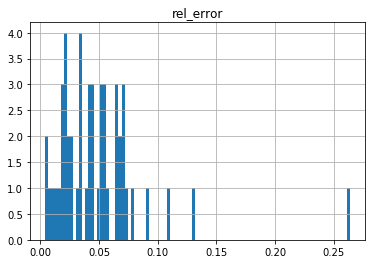

In [49]:
error_state.hist(bins=100)

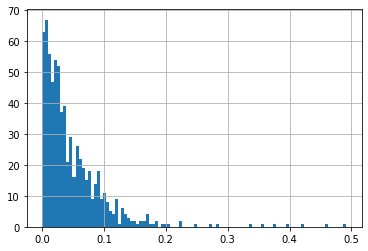

In [50]:
error["rel_error"].hist(bins=100)

Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

In the `mdp_testing.py` file, there are also various other visualization tools to help compare these results with real data! Most of these require you to have the original dataframe of the full data, as well as the clustered data which you can access at `model.df_trained`.

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

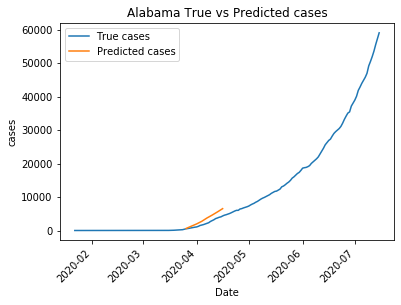

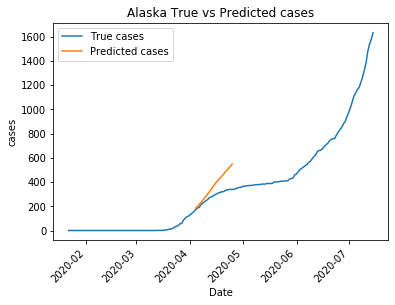

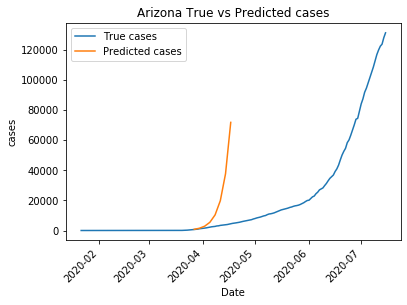

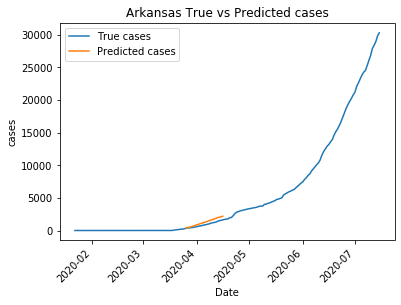

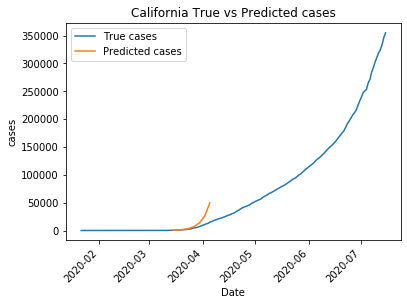

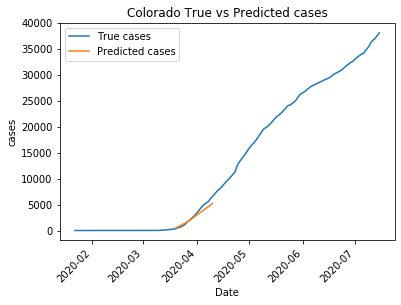

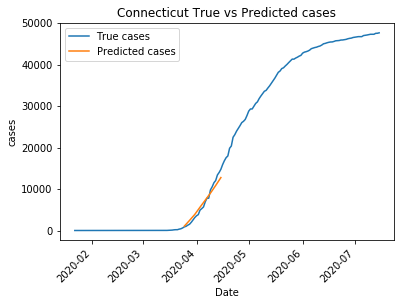

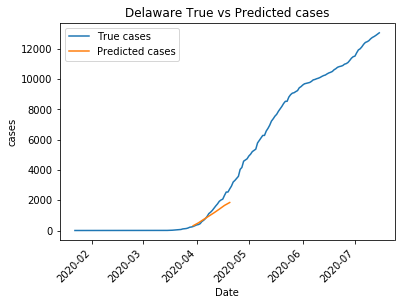

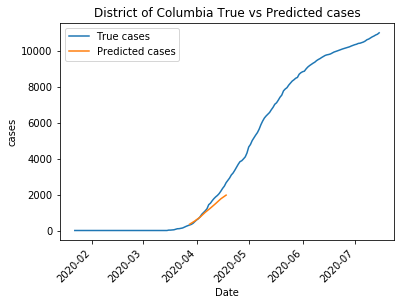

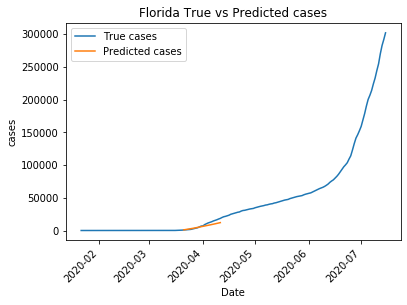

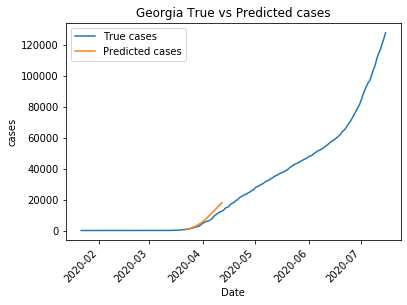

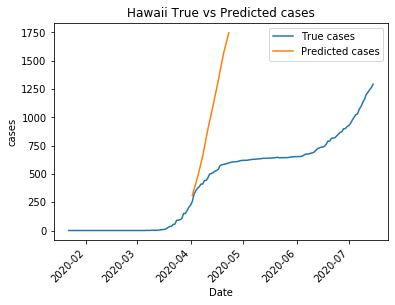

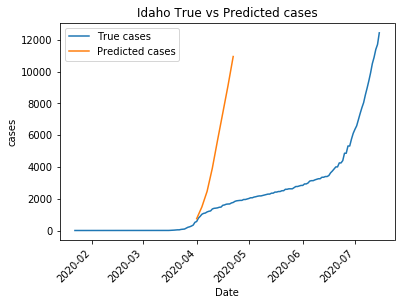

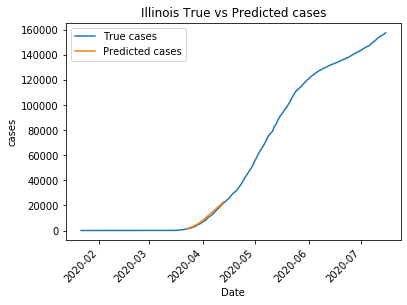

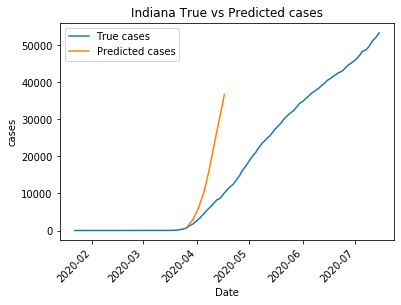

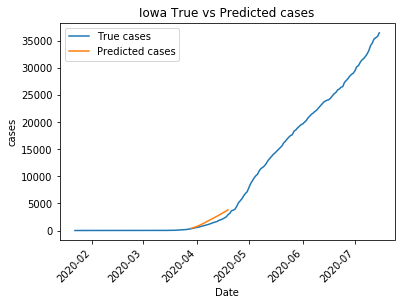

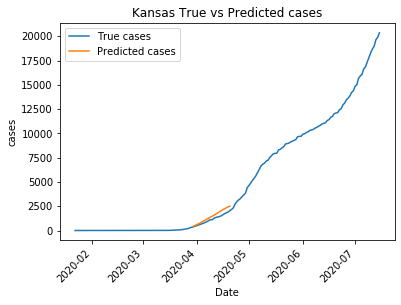

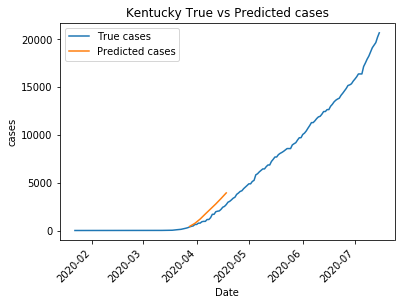

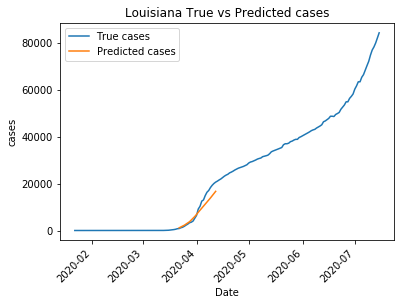

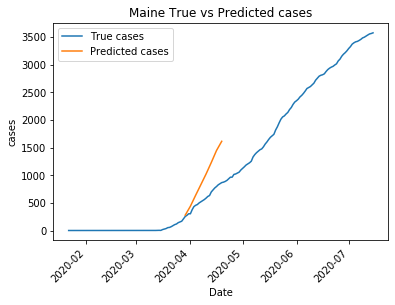

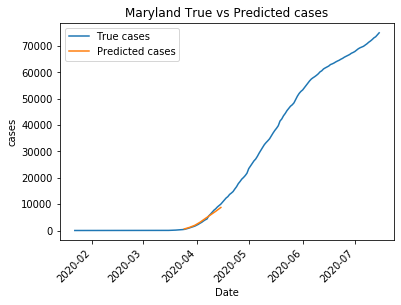

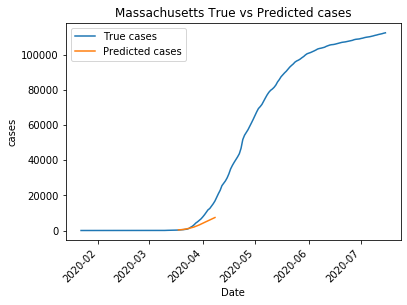

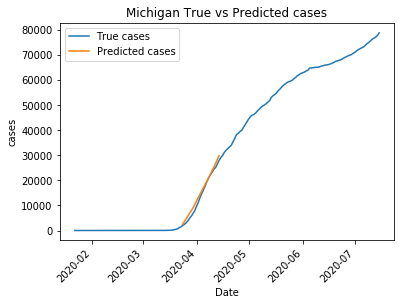

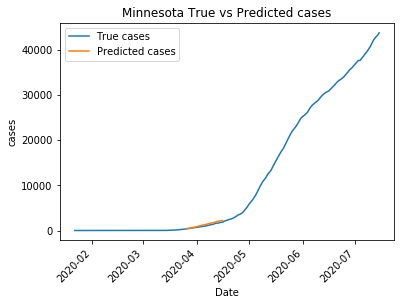

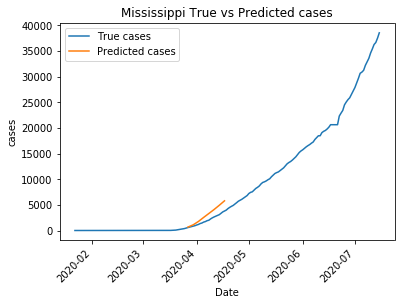

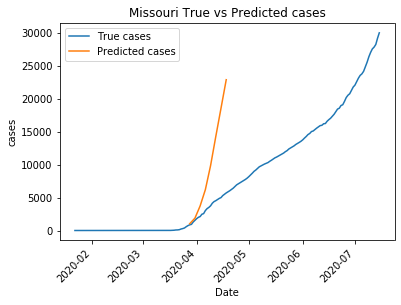

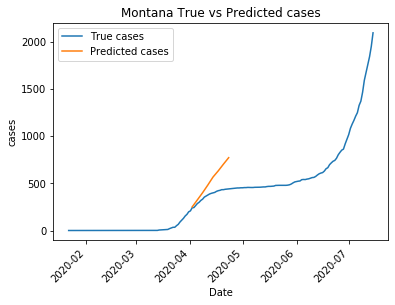

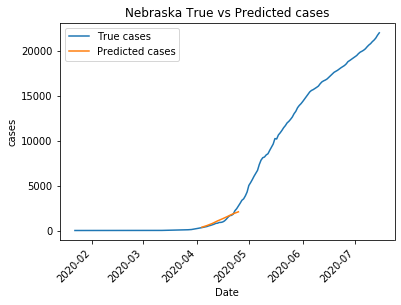

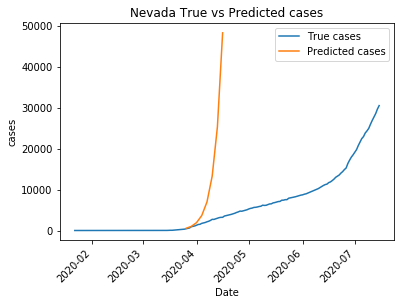

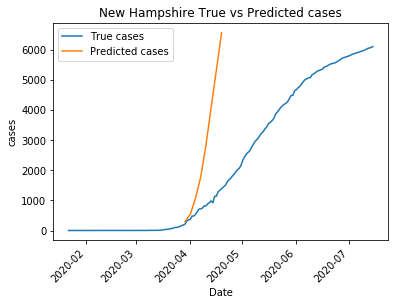

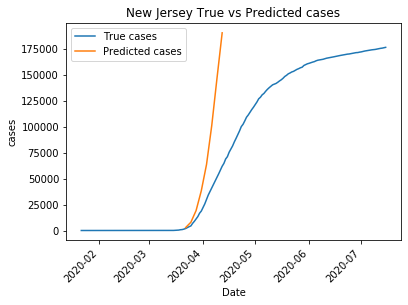

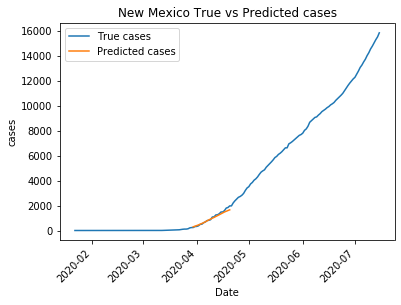

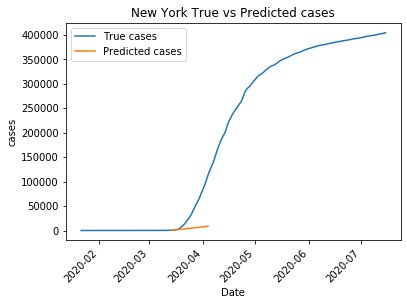

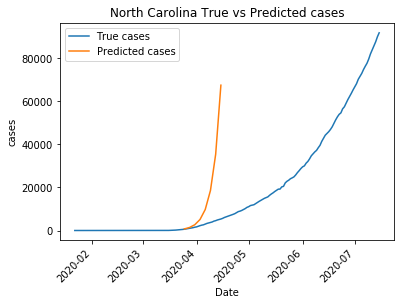

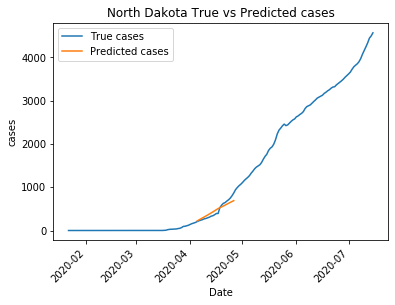

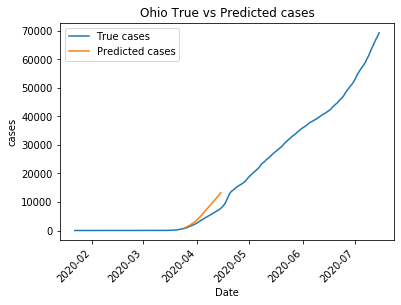

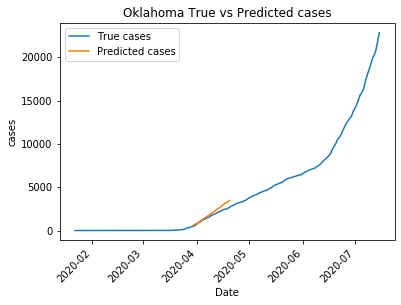

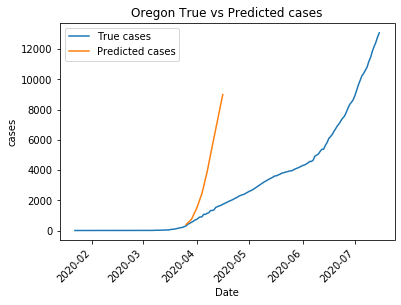

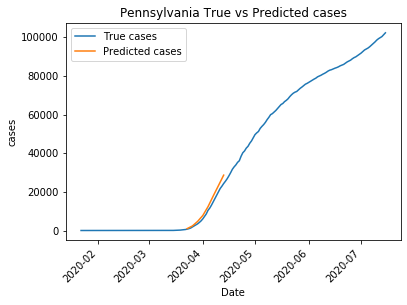

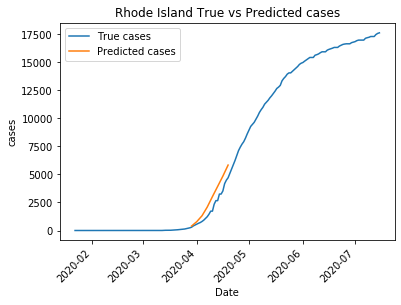

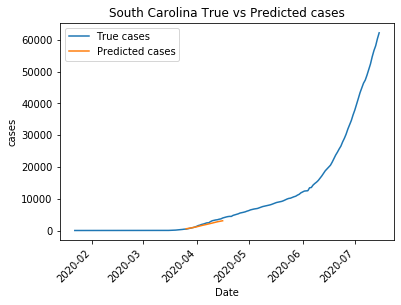

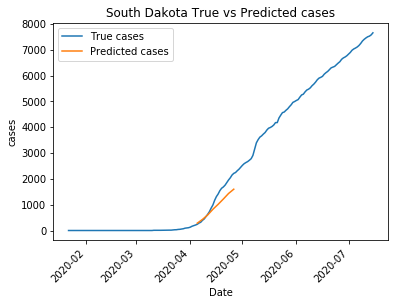

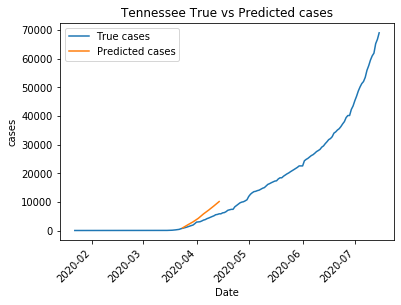

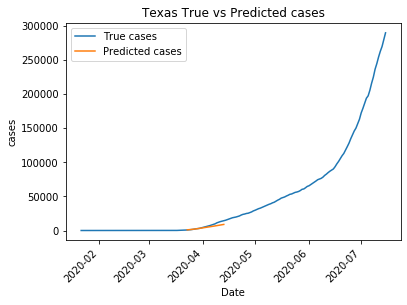

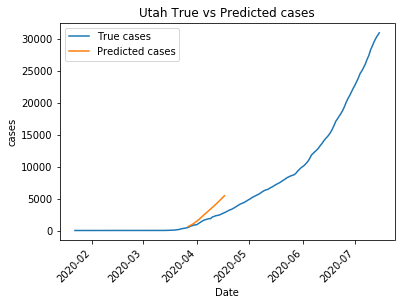

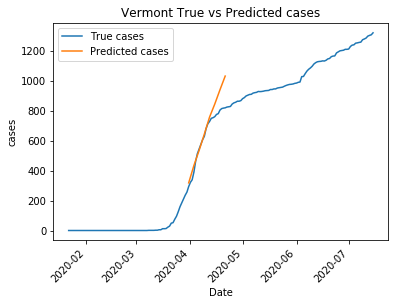

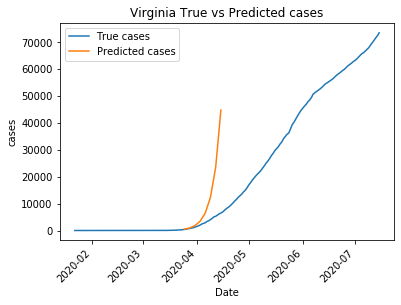

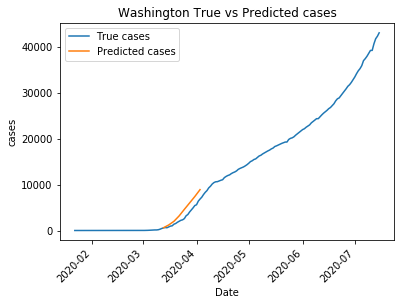

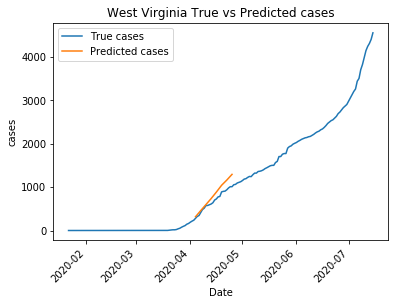

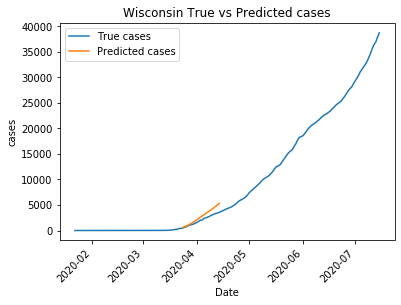

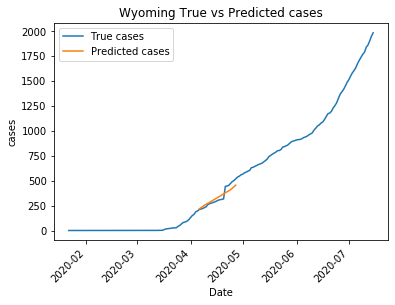

In [36]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 20, from_first=True)

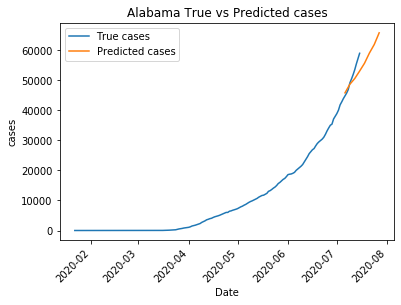

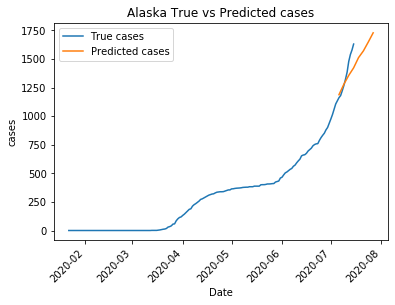

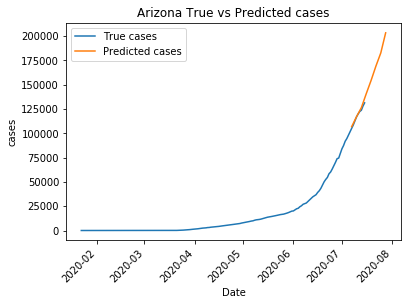

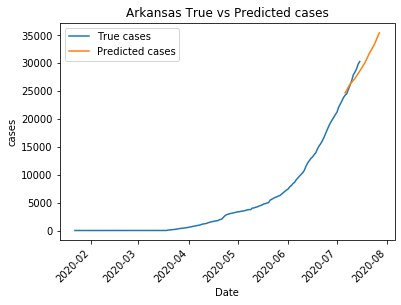

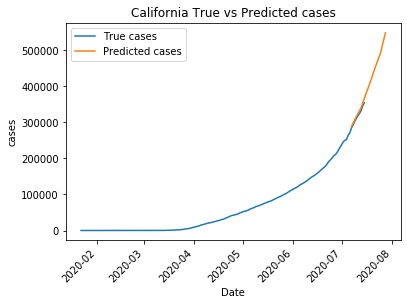

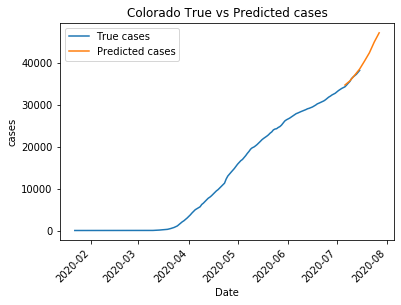

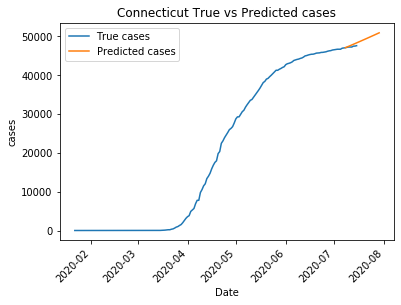

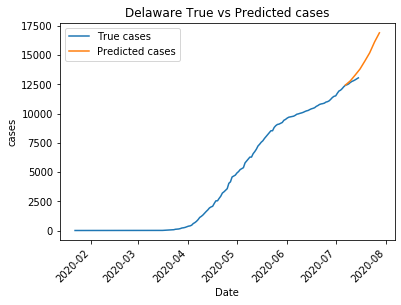

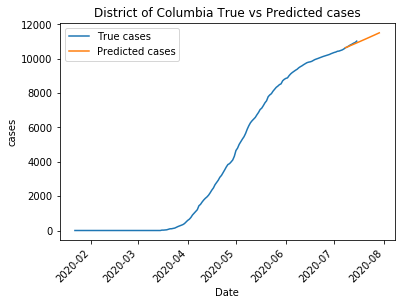

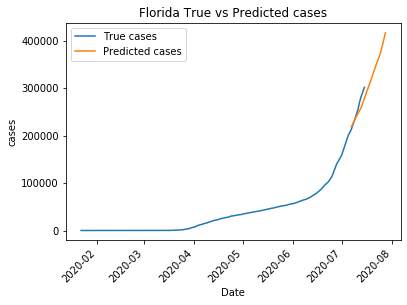

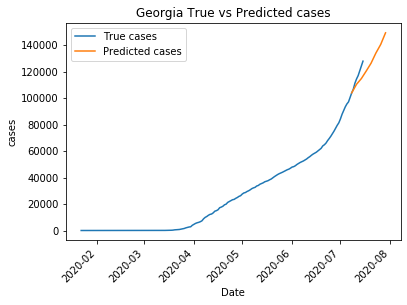

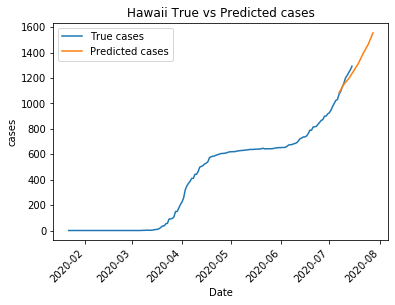

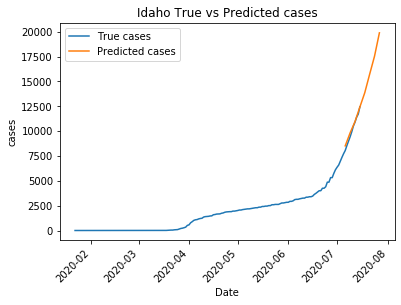

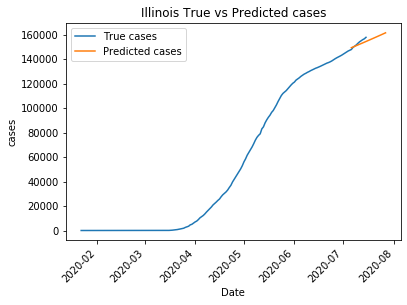

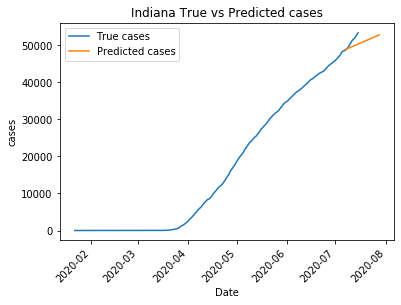

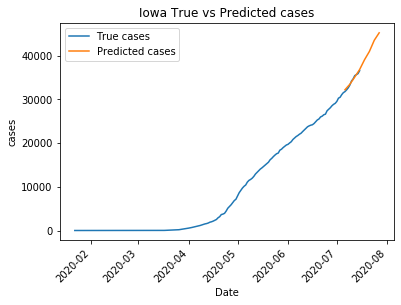

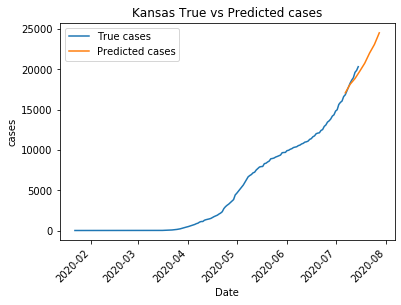

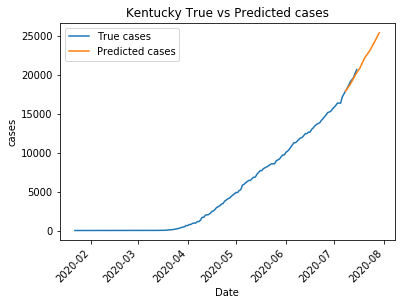

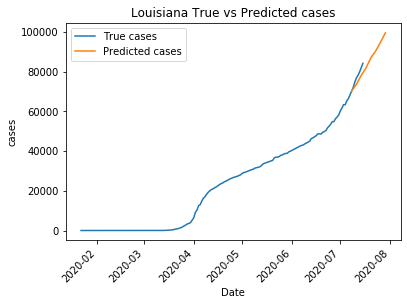

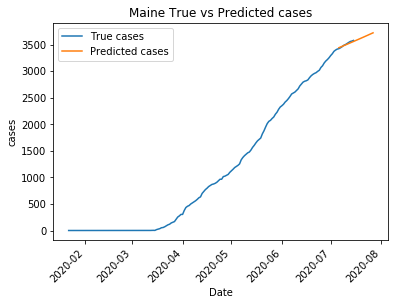

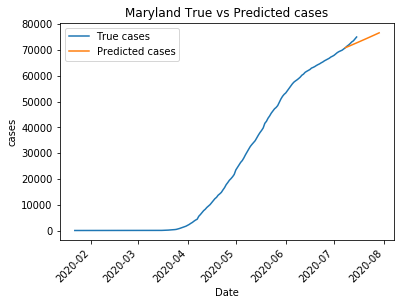

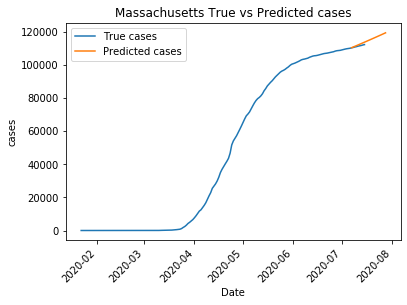

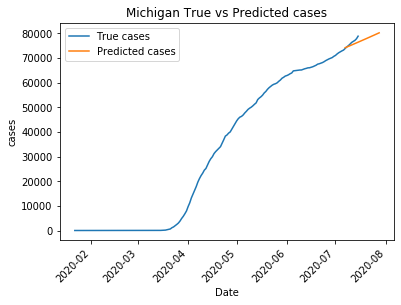

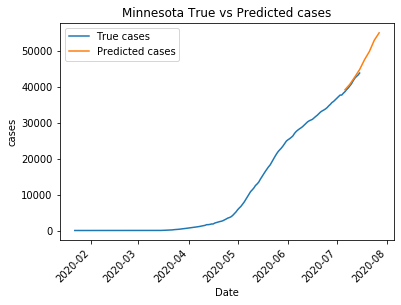

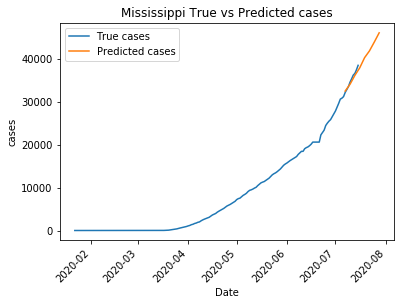

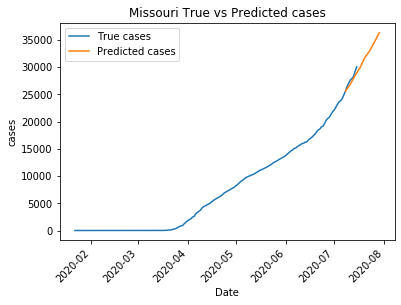

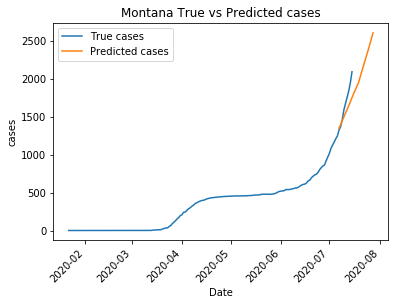

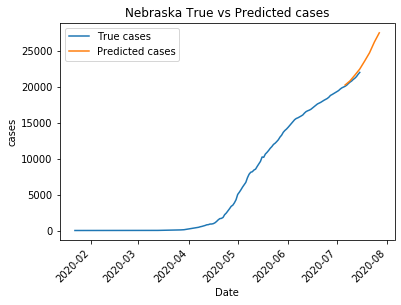

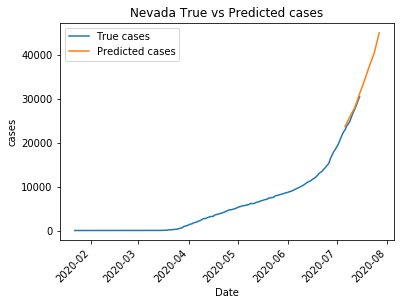

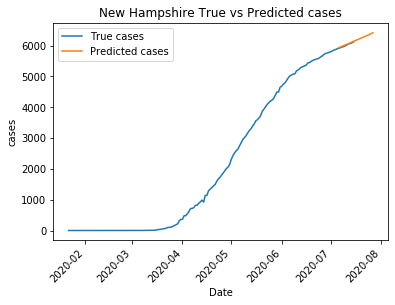

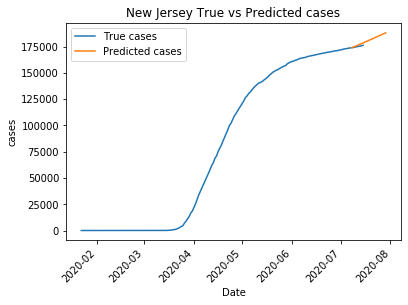

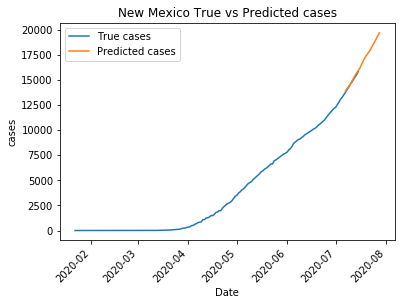

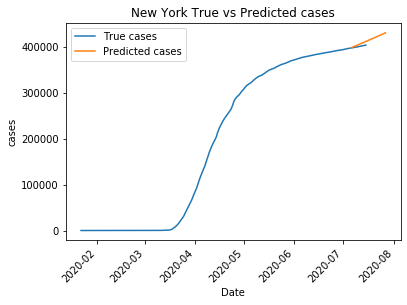

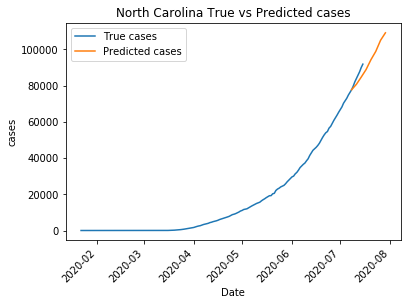

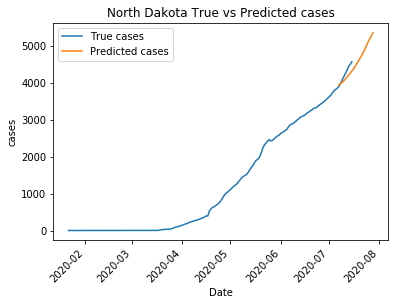

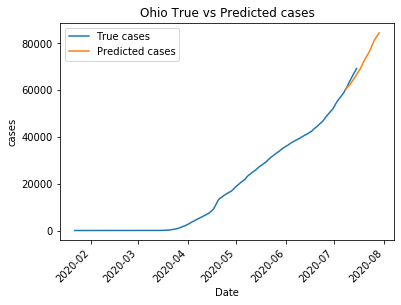

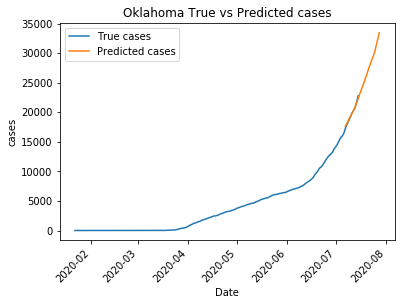

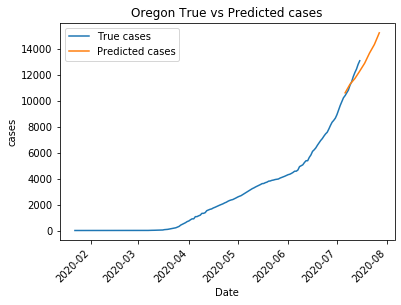

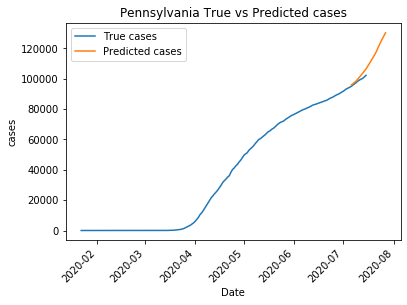

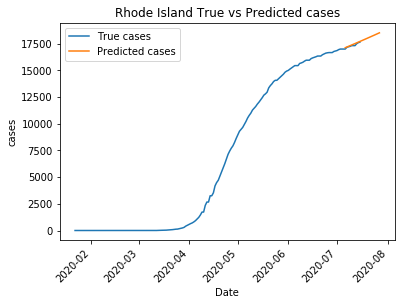

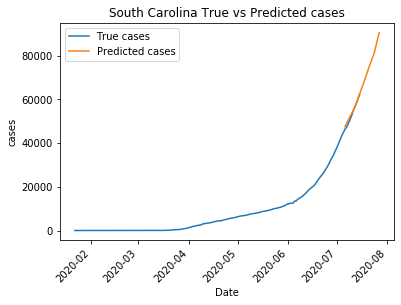

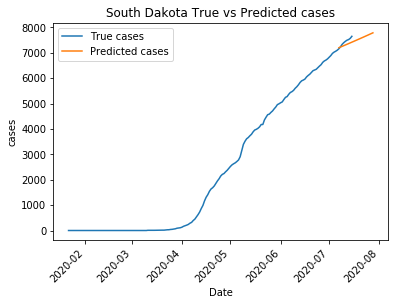

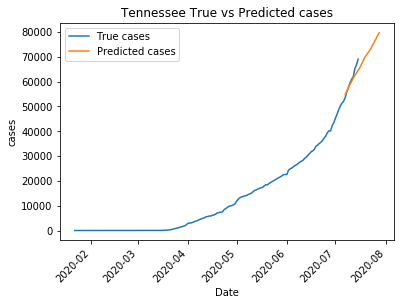

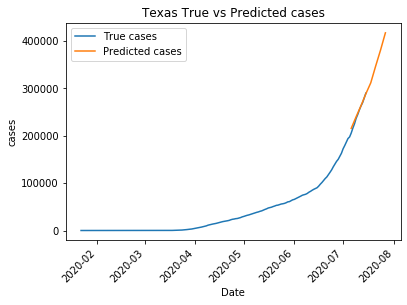

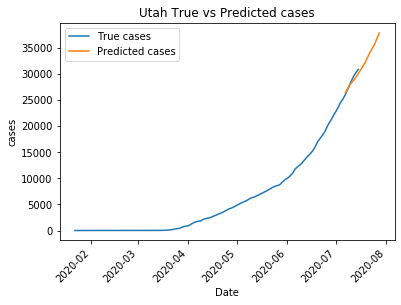

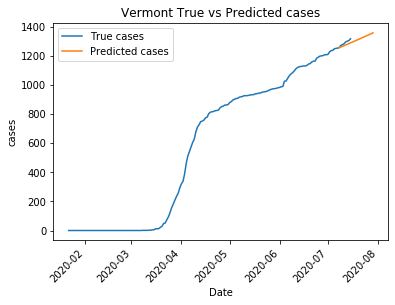

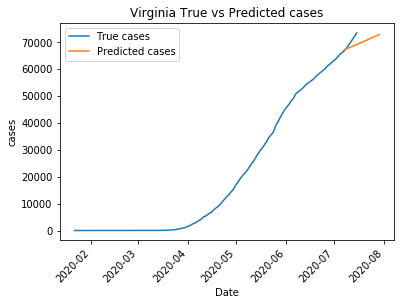

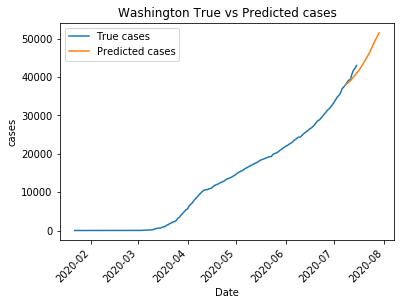

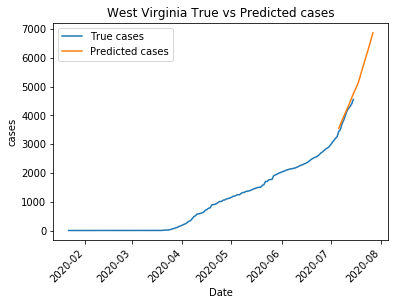

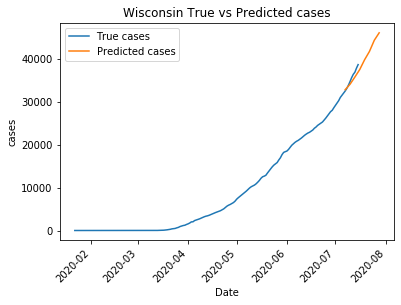

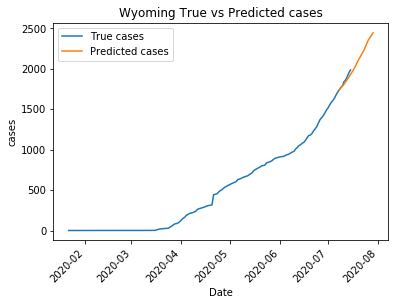

In [37]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 20, from_first=False)

## $\textbf{Grid Search Analysis}$

In [19]:
with open(os.path.join(MODEL_PATH, "mdp_gs_cases_wo_act.pickle"), 'rb') as filehandler:
    mgs = pickle.load(filehandler)

In [6]:
mgs.testing_error

{0: 0.04905599473922093,
 1: 0.04699905461008597,
 2: 0.11725798716676235,
 3: 0.11780364780184498,
 4: 0.572779629913963,
 5: 0.710317378733401,
 6: 0.06656367013281196,
 7: 0.0652597889122737,
 8: 0.16463223932306678,
 9: 0.16489206342650103,
 10: 4.03678140051655,
 11: 0.627548352500398,
 12: 0.08041912101287939,
 13: 0.09905220011979994,
 14: 0.24582251240394704,
 15: 0.2631216980346289,
 16: 0.5024158106922457,
 17: 0.4773146484350817}

In [7]:
mgs.best_estimator_

MDPModel(target=cases, horizon=5, days_avg=3,distance_threshold=10pct, n_iter=120, classification_algorithm=RandomForestClassifier, features_list=['mobility_score_trend', 'cases_pct3', 'cases_pct5'],action_thresh=([], 0))

In [8]:
import operator
key_opt = min(mgs.testing_error.items(), key=operator.itemgetter(1))[0]
m_opt = mgs.all_estimators_dict[key_opt]
m_opt

MDPModel(target=cases, horizon=5, days_avg=3,distance_threshold=10pct, n_iter=120, classification_algorithm=RandomForestClassifier, features_list=['mobility_score_trend', 'cases_pct3', 'cases_pct5'],action_thresh=([], 0))

In [9]:
m_opt.optimal_cluster_size

53

In [16]:
# Import full dataset and convert time col to time object
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.loc[:, [date_colname]]= pd.to_datetime(df[date_colname])

df_pred = pd.concat([m_opt.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m_opt.region_colname, "TIME"]).join(df.rename(columns={m_opt.date_colname: "TIME"}).set_index([m_opt.region_colname, "TIME"])[m_opt.target_colname], lsuffix="_", rsuffix="").loc[:, [m_opt.target_colname]].reset_index().set_index(m_opt.region_colname)
df_pred.set_index(m_opt.region_colname, inplace=True)
error = mape(df_pred, df_true, m_opt.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m_opt.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

rel_error
state                          
New York               0.004303
New Jersey             0.005244
Iowa                   0.007790
Vermont                0.008941
Tennessee              0.014480
Pennsylvania           0.014613
Rhode Island           0.014756
Virginia               0.016518
Louisiana              0.017046
Montana                0.019139
California             0.019717
Connecticut            0.022033
Mississippi            0.023204
Ohio                   0.023896
Massachusetts          0.025037
South Dakota           0.026040
Hawaii                 0.027309
Wisconsin              0.029549
Illinois               0.030230
Idaho                  0.030637
Wyoming                0.032238
Arizona                0.033295
Colorado               0.033804
Georgia                0.034465
Maine                  0.035497
Utah                   0.039705
West Virginia          0.040530
Florida                0.040942
Minnesota              0.041992
Oregon                 0.043170
Maryland               0.043327
Indiana                0.043525
Oklahoma               0.044250
North Carolina         0.049794
Arkansas               0.051807
Washington             0.052409
New Hampshire          0.053799
Missouri               0.053915
District of Columbia   0.055273
New Mexico             0.056285
Nevada                 0.056639
Kansas                 0.060521
Kentucky               0.060804
Alaska                 0.066673
Michigan               0.070184
Alabama                0.076399
Texas                  0.088725
Nebraska               0.092052
Delaware               0.092603
South Carolina         0.097504
North Dakota           0.223651

In [17]:
# computing the out of sample error
error_state.describe()

rel_error
count  51.000000
mean    0.044044
std     0.034563
min     0.004303
25%     0.023550
50%     0.039705
75%     0.054594
max     0.223651

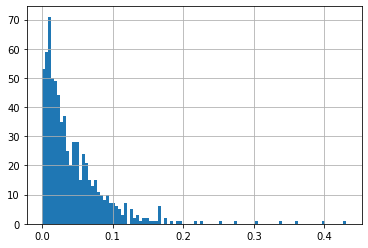

In [18]:
error["rel_error"].hist(bins=100)

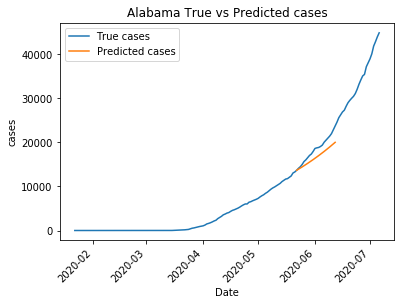

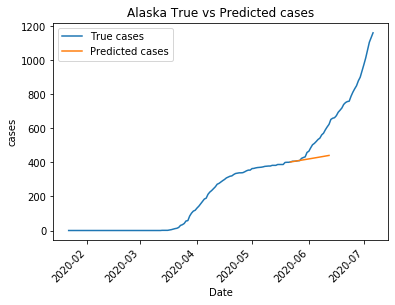

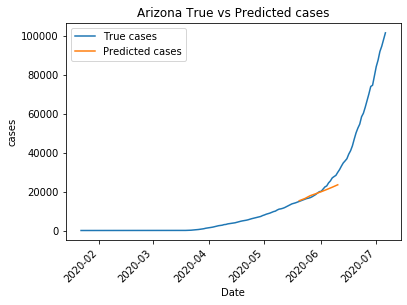

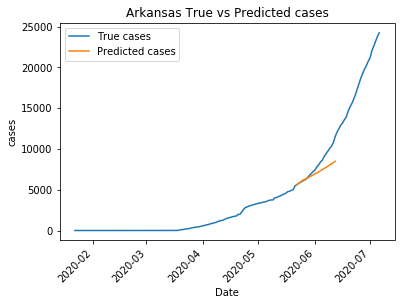

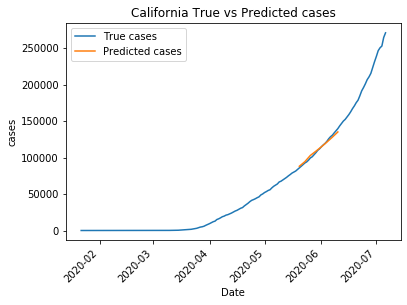

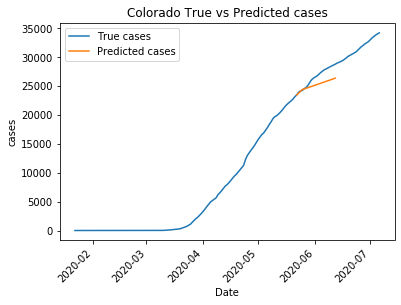

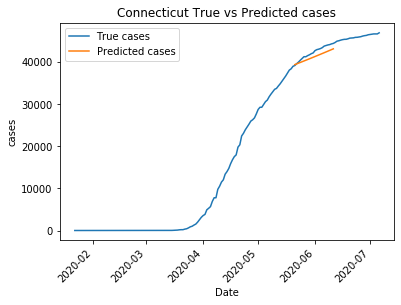

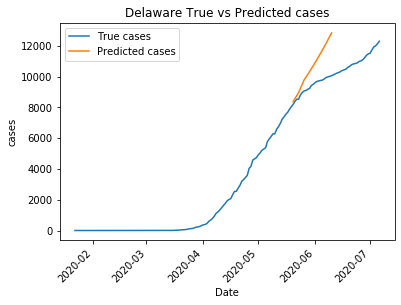

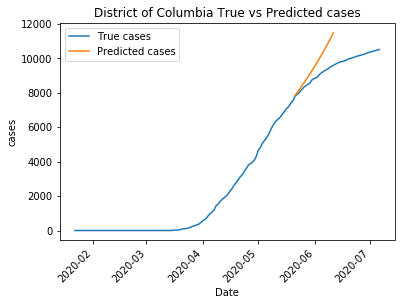

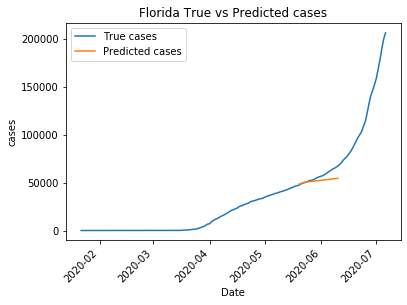

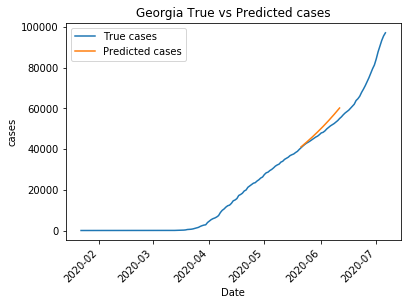

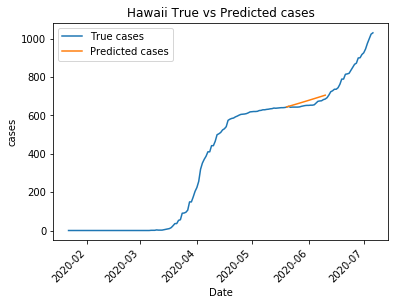

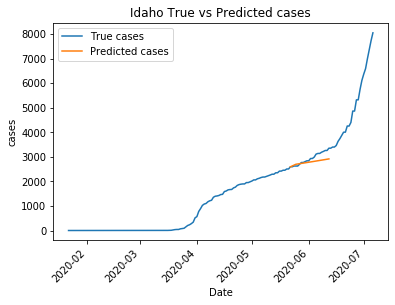

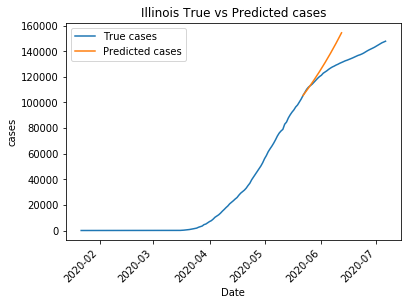

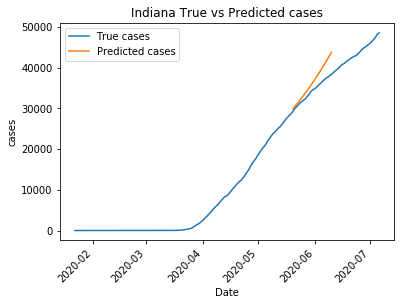

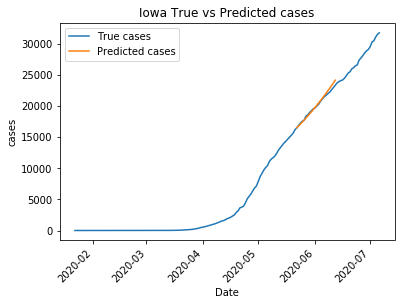

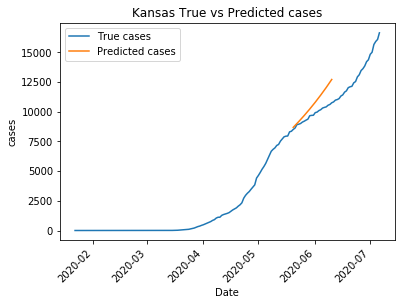

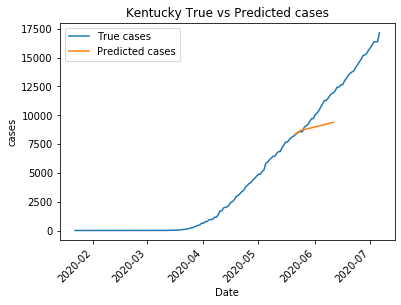

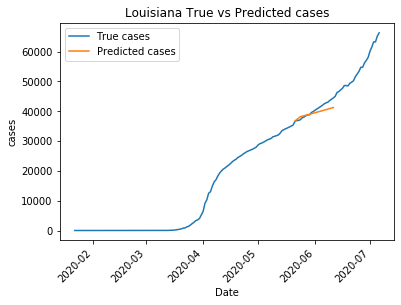

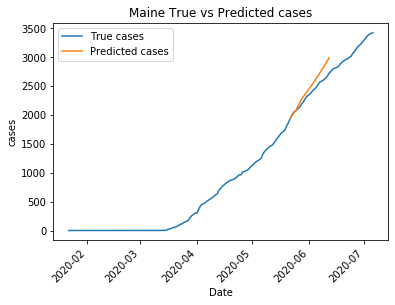

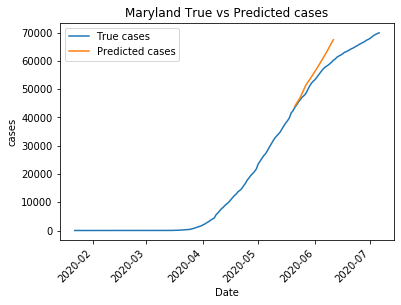

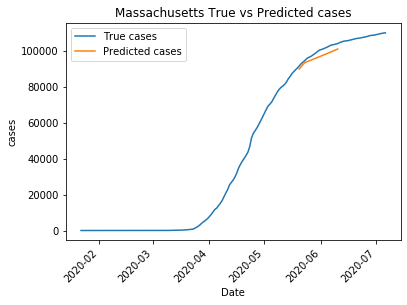

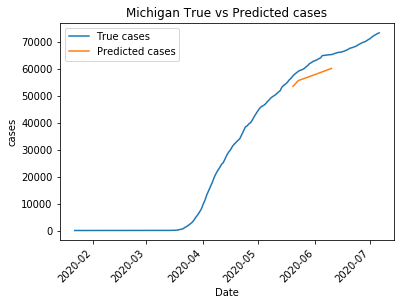

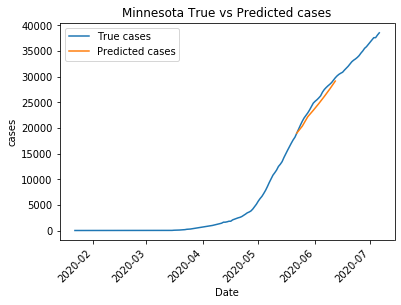

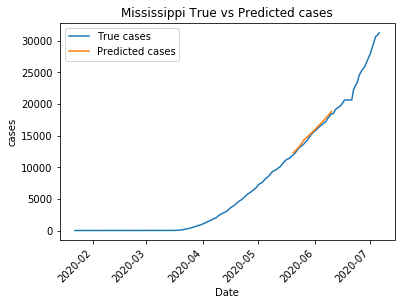

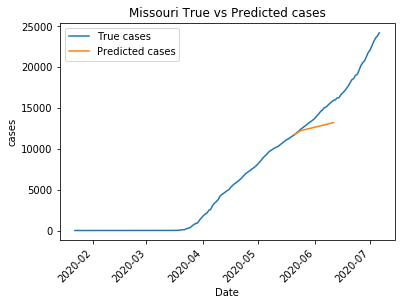

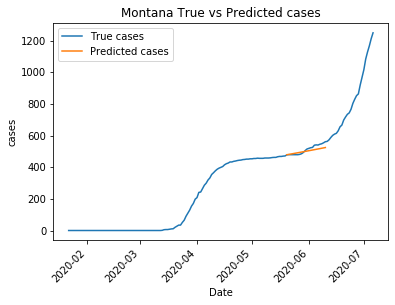

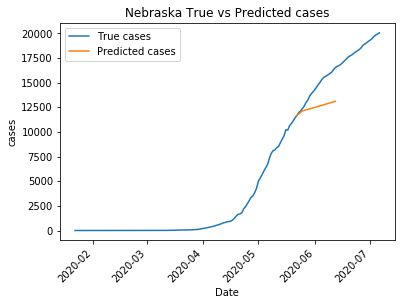

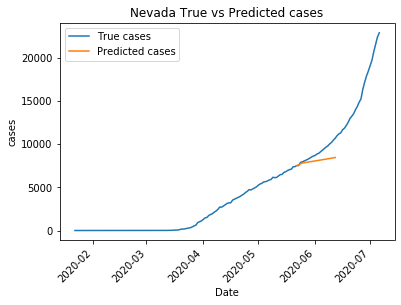

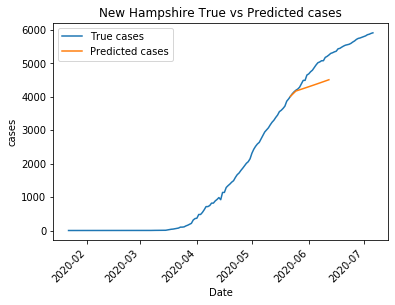

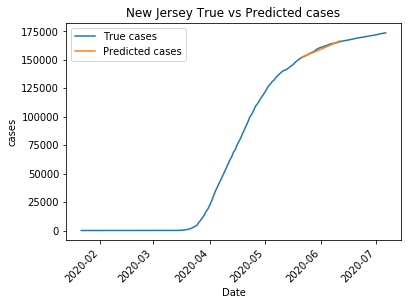

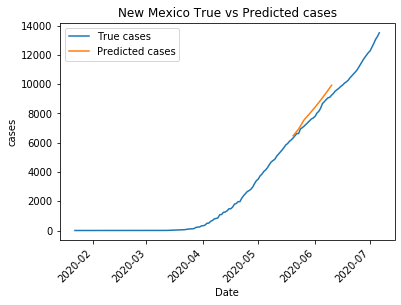

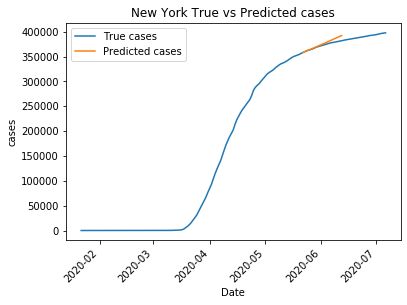

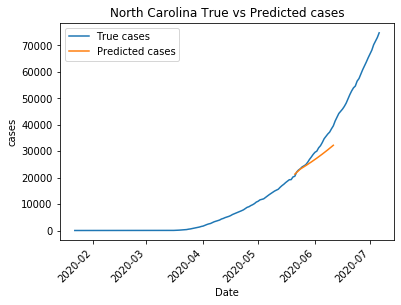

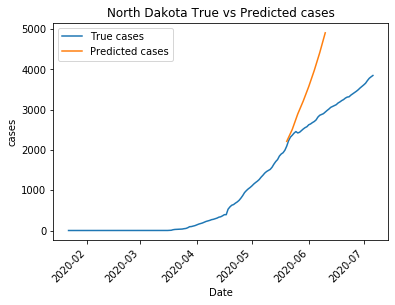

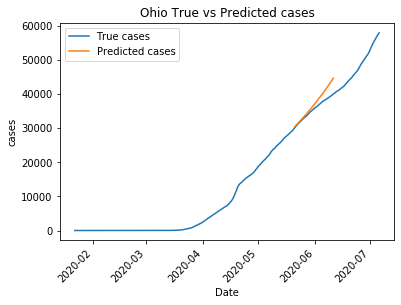

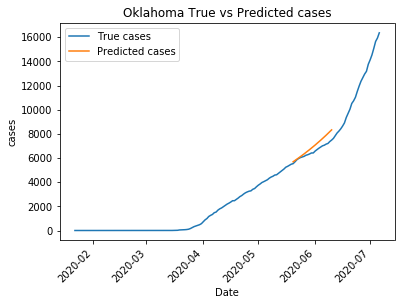

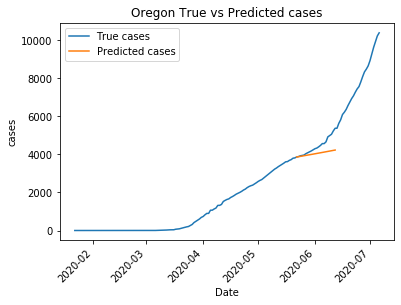

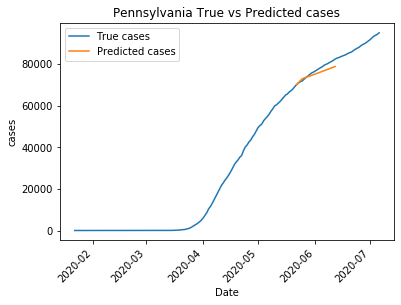

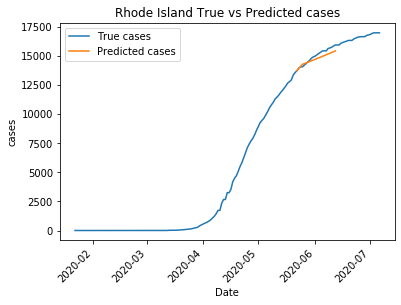

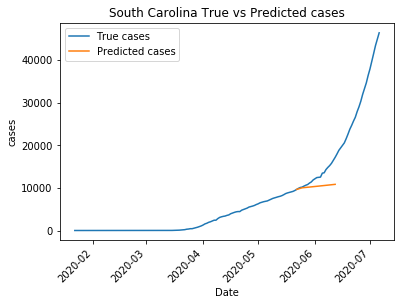

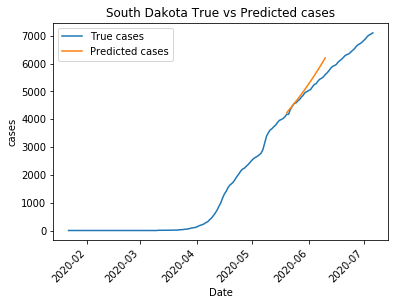

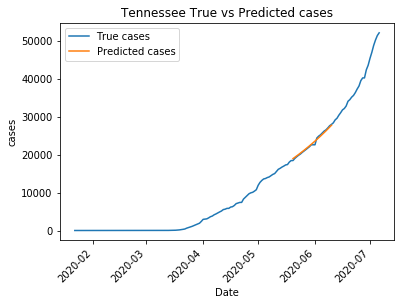

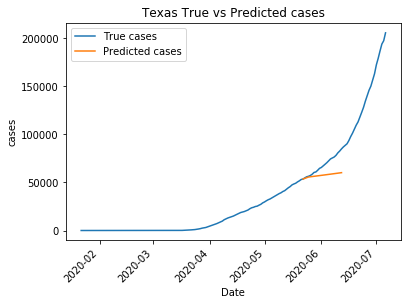

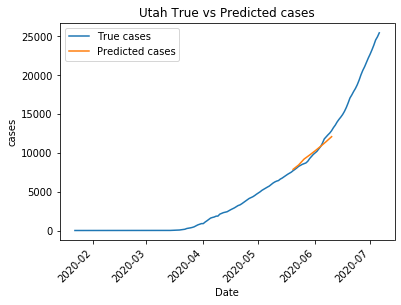

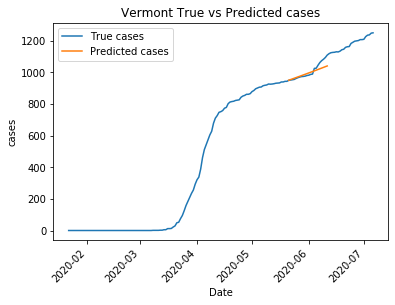

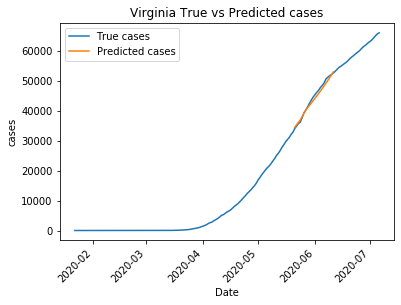

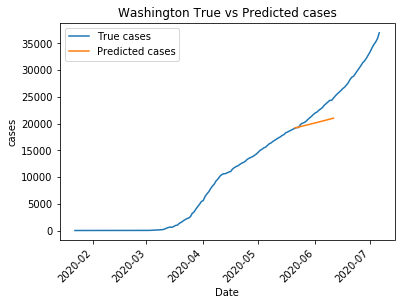

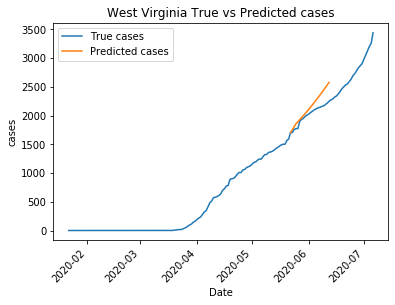

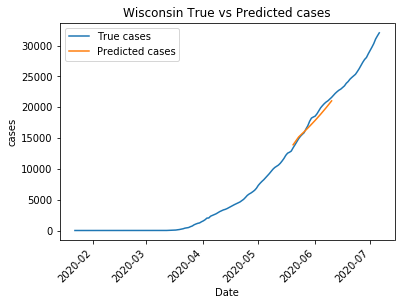

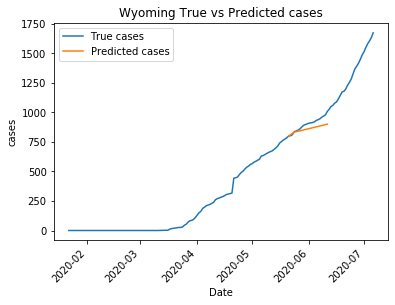

In [20]:
for region in m_opt.df_trained.index:
    plot_pred(m_opt, region, df, 20, from_first=False)